# 数据获取

In [36]:
# 载入依赖包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InteractiveShell.ast_node_interactivity = 'last'

# 画图的主题设计
sns.set_theme()
sns.set_context('notebook')

In [37]:
# 加载数据
data_user = pd.read_csv(r"D:\DA\4.python\Project\tianchi_mobile_recommend_train_user\tianchi_mobile_recommend_train_user.csv")
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [38]:
# 查看数据集量级
print('整体数据的大小是：',len(data_user))
print('数据集中用户数量是：',len(set(data_user['user_id'])))
print('数据集中商品数量是：',len(set(data_user['item_id'])))
print('数据集中商品类别数量是：',len(set(data_user['item_category'])))

整体数据的大小是： 1048575
数据集中用户数量是： 8477
数据集中商品数量是： 701609
数据集中商品类别数量是： 7095


本次分析的数据集包含了8477个用户在1个月内的的100多万条购物行为数据，商品总数量超过70万，分布在7095个类目中。

# 数据处理

In [39]:
# 分割天(date)和小时(hour)
data_user['date'] = data_user['time'].map(lambda x: x.split()[0])
data_user['hour'] = data_user['time'].map(lambda x: x.split()[1])
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [40]:
# 添加星期字段，分析周内行为模式
data_user['date'] = pd.to_datetime(data_user['date'])
data_user["week_num"] = data_user['date'].dt.weekday+1
# 删除字段time和user_geohash
data_user.drop('time',axis=1,inplace=True,errors='ignore')
data_user.drop('user_geohash',axis=1,inplace=True,errors='ignore')
data_user.head()

,user_id,item_id,behavior_type,item_category,date,hour,week_num
0,98047837,232431562,1,4245,2014-12-06,02,6
1,97726136,383583590,1,5894,2014-12-09,20,2
2,98607707,64749712,1,2883,2014-12-18,11,4
3,98662432,320593836,1,6562,2014-12-06,10,6
4,98145908,290208520,1,13926,2014-12-16,21,2


In [41]:
# 查看字段类型：
data_user.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
item_category             int64
date             datetime64[ns]
hour                     object
week_num                  int64
dtype: object

In [42]:
data_user['user_id'] = data_user['user_id'].astype('object')
data_user['item_id'] = data_user['item_id'].astype('object')
data_user['item_category'] = data_user['item_category'].astype('object')
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['hour'] = data_user['hour'].astype('int64')
data_user['week_num'] = data_user['week_num'].astype('object')

data_user.dtypes

user_id                  object
item_id                  object
behavior_type             int64
item_category            object
date             datetime64[ns]
hour                      int64
week_num                 object
dtype: object

# 数据分析&可视化

## Part1. 流量分析

### 1.基于周级别访问流量分析

In [58]:
filtered_data = data_user[~data_user.date.between('2014-12-08', '2014-12-14')]
# 剔除双十二所在一周的数据，避免对分析产生影响
week_stats = filtered_data.groupby('week_num',as_index=False).agg(
    pv_week=('user_id', 'count'),    # 计算PV: PageView
    uv_week=('user_id', 'nunique')   # 计算UV：UniqueView
)
week_stats


,week_num,pv_week,uv_week
0,1,100158,6872
1,2,131793,7276
2,3,129293,7260
3,4,127540,7252
4,5,89226,6518
5,6,96087,6601
6,7,101682,6682


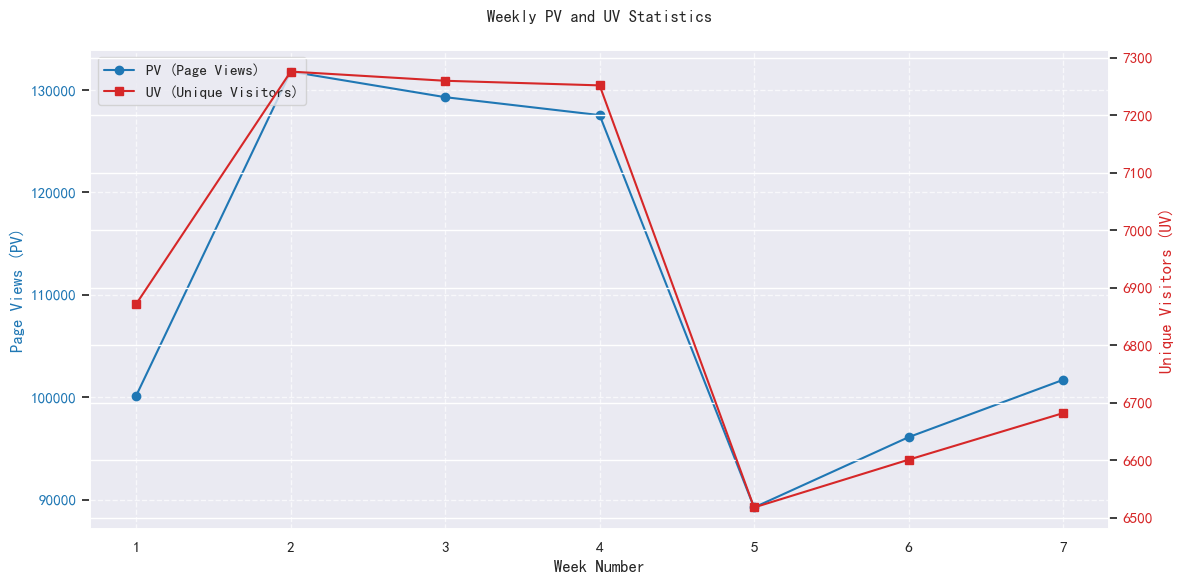

In [59]:
import matplotlib.pyplot as plt

# 假设 week_stats 是前面代码生成的数据框
# 示例数据 (如果实际数据不存在，可以取消下面的注释使用示例数据)
# week_stats = pd.DataFrame({
#     'week_num': [1, 2, 3, 4],
#     'pv_week': [1500, 2200, 1800, 2500],
#     'uv_week': [800, 950, 850, 1100]
# })

plt.figure(figsize=(12, 6))

# 创建第一个坐标轴
ax1 = plt.gca()
# 创建第二个坐标轴，共享x轴
ax2 = ax1.twinx()

# 绘制PV折线图 (左侧y轴)
color = 'tab:blue'
ax1.plot(week_stats['week_num'], week_stats['pv_week'], 
         color=color, marker='o', label='PV (Page Views)')
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Page Views (PV)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# 绘制UV折线图 (右侧y轴)
color = 'tab:red'
ax2.plot(week_stats['week_num'], week_stats['uv_week'], 
         color=color, marker='s', label='UV (Unique Visitors)')
ax2.set_ylabel('Unique Visitors (UV)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 添加标题和图例
plt.title('Weekly PV and UV Statistics', pad=20)

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 调整布局
plt.tight_layout()
plt.show()

结果显示在周二到周四期间流量达到高点，可能的原因是用户习惯利用通勤、午休等碎片时间（周二至周四工作稳定后）浏览淘宝，周五晚通常是线下社交、聚餐、娱乐活动的高峰期（如看电影、聚会），用户减少线上购物时间，而周末可能更倾向于线下活动或长视频娱乐；另外周中促销活动，比如淘宝的“淘宝直播”“聚划算”等栏目常在周二至周四设置专场活动（如“周二超级直播日”），吸引流量。

### 2. 基于天级别访问流量分析

In [45]:
# 计算PV: PageView , UV: UniqueView
# pv_daily = data_user.groupby('date',as_index=False)['user_id'].count()#pv_daily = pv_daily.reset_index() 
# pv_daily = pv_daily.rename(columns = {'user_id':'pv_daily'})

# 计算UV
# uv_daily = data_user.groupby('date',as_index=False)['user_id'].apply(lambda x: len(x.unique()))
# uv_daily = uv_daily.rename(columns = {'user_id':'uv_daily'})

In [46]:
daily_stats = data_user.groupby('date',as_index=False).agg(
    pv_daily=('user_id', 'count'),    # 计算PV: PageView
    uv_daily=('user_id', 'nunique')   # 计算UV：UniqueView
)
daily_stats

,date,pv_daily,uv_daily
0,2014-11-18,31581,4283
1,2014-11-19,30567,4301
2,2014-11-20,30598,4276
3,2014-11-21,28039,4144
4,2014-11-22,31283,4122
5,2014-11-23,32458,4317
6,2014-11-24,32292,4391
7,2014-11-25,31510,4298
8,2014-11-26,30792,4275
9,2014-11-27,31338,4262


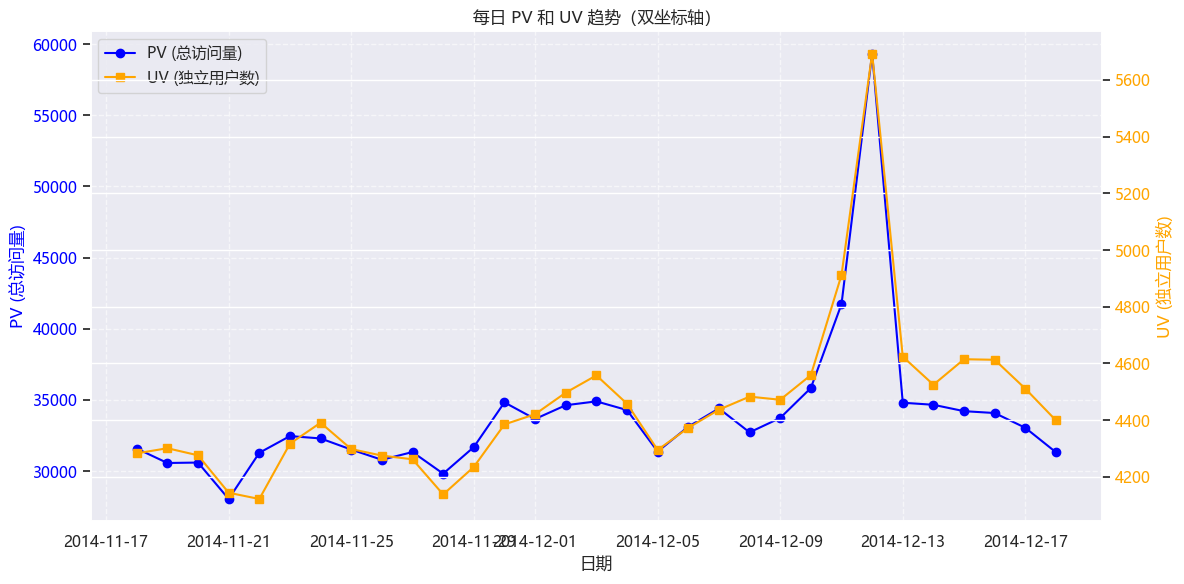

In [47]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Windows
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 双坐标轴绘图
fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：PV
ax1.plot(daily_stats['date'], daily_stats['pv_daily'], 
         label='PV (总访问量)', marker='o', color='blue')
ax1.set_xlabel('日期')
ax1.set_ylabel('PV (总访问量)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# 右轴：UV
ax2 = ax1.twinx()
ax2.plot(daily_stats['date'], daily_stats['uv_daily'], 
         label='UV (独立用户数)', marker='s', color='orange')
ax2.set_ylabel('UV (独立用户数)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('每日 PV 和 UV 趋势（双坐标轴）')
plt.tight_layout()
plt.show()

可以看出，不管是PV还是UV趋势，均在12号的时候出现了一个尖峰，这是双十二的用户集中消费导致的变化。

### 3. 基于小时级别访问流量分析

上面对不同访问量进行分析，分析的时间跨度是每天。另外用户在一天当中对淘宝的使用也有一定规律。因此为了探索这个规律，可以按照每小时统计用户的访问量和独立访问量。

In [48]:
#pv_hour = data_user.groupby('hour',as_index=False)['user_id'].count()
#pv_hour = pv_hour.rename(columns = {'user_id':'pv_hour'})

#uv_hour = data_user.groupby('hour',as_index=False)['user_id'].apply(lambda x: len(x.unique()))
#uv_hour = uv_hour.rename(columns = {'user_id':'uv_hour'})

data_user.groupby('hour',as_index=False).agg(
    pv_hour=('user_id', 'count'),    # 总记录数
    uv_hour=('user_id', 'nunique')   # 独立用户数
)

,hour,pv_hour,uv_hour
0,0,44774,4067
1,1,23376,2519
2,2,12897,1651
3,3,8624,1234
4,4,6887,1098
5,5,7791,1241
6,6,13626,2171
7,7,24623,3615
8,8,33935,4740
9,9,41733,5326


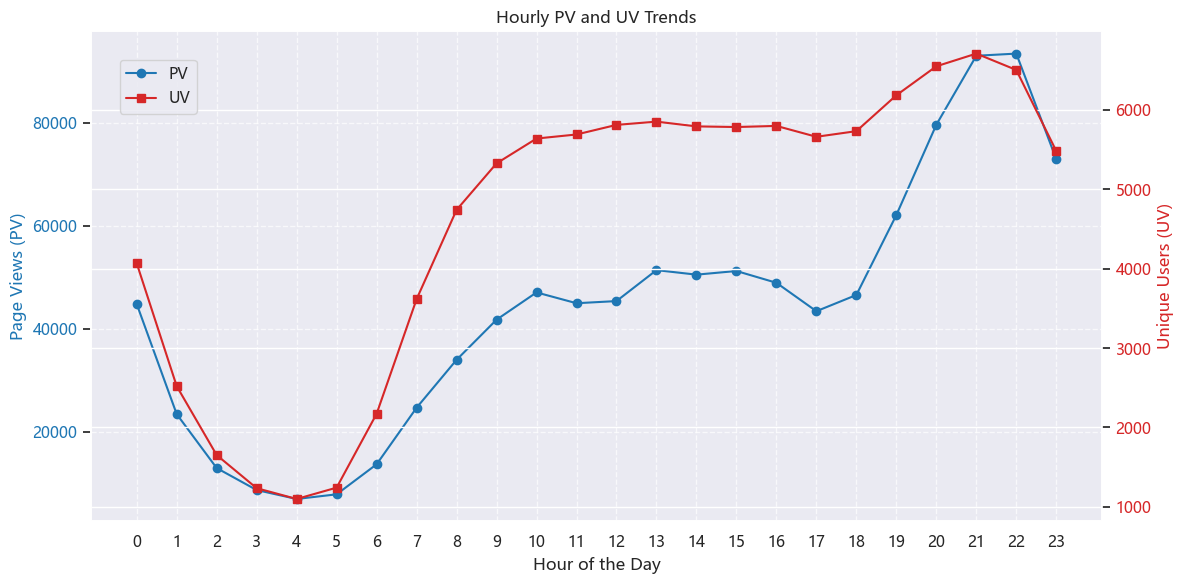

In [49]:
import matplotlib.pyplot as plt

# 假设您的聚合结果存储在变量 hourly_stats 中
hourly_stats = data_user.groupby('hour', as_index=False).agg(
    pv_hour=('user_id', 'count'),    # 总记录数
    uv_hour=('user_id', 'nunique')   # 独立用户数
)

# 创建画布和主坐标轴
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制 PV（左轴）
color_pv = 'tab:blue'
ax1.plot(hourly_stats['hour'], hourly_stats['pv_hour'], color=color_pv, marker='o', label='PV')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Page Views (PV)', color=color_pv)
ax1.tick_params(axis='y', labelcolor=color_pv)
ax1.set_xticks(range(0, 24))  # 确保显示所有小时
ax1.grid(True, linestyle='--', alpha=0.7)

# 创建副坐标轴（共享同一x轴）
ax2 = ax1.twinx()
color_uv = 'tab:red'
ax2.plot(hourly_stats['hour'], hourly_stats['uv_hour'], color=color_uv, marker='s', label='UV')
ax2.set_ylabel('Unique Users (UV)', color=color_uv)
ax2.tick_params(axis='y', labelcolor=color_uv)

# 添加标题和图例
plt.title('Hourly PV and UV Trends')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))  # 统一图例位置

plt.tight_layout()
plt.show()

可以看出，UV和PV在18点后开始增长，这个时间点正是下班高峰期。另外PV的高峰值出现在20点之后，可能的原因大多数人在这个时间点结束了一天的工作，有闲暇时间网购。 另外，凌晨2点之后，PV/UV的趋势一致，均是一天中流量最小的时间段，符合常理。

从“日PV/UV”趋势看，双十二当天的总体流量会出现明显的峰值。那么双十二当天基于小时的用户访问量是否会有变化？

In [50]:
# 计算双十二当天每小时的PV
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']
pv_hour_1212 = data_user_1212.groupby('hour',as_index=False)['user_id'].count()
pv_hour_1212 = pv_hour_1212.rename(columns = {'user_id':'1212_pv_hour'})
pv_hour_1212

,hour,1212_pv_hour
0,0,4441
1,1,2061
2,2,1001
3,3,497
4,4,434
5,5,553
6,6,1099
7,7,1885
8,8,2380
9,9,2832


为了方便对比，我们和30日总体的小时级别PV变化趋势做对比：

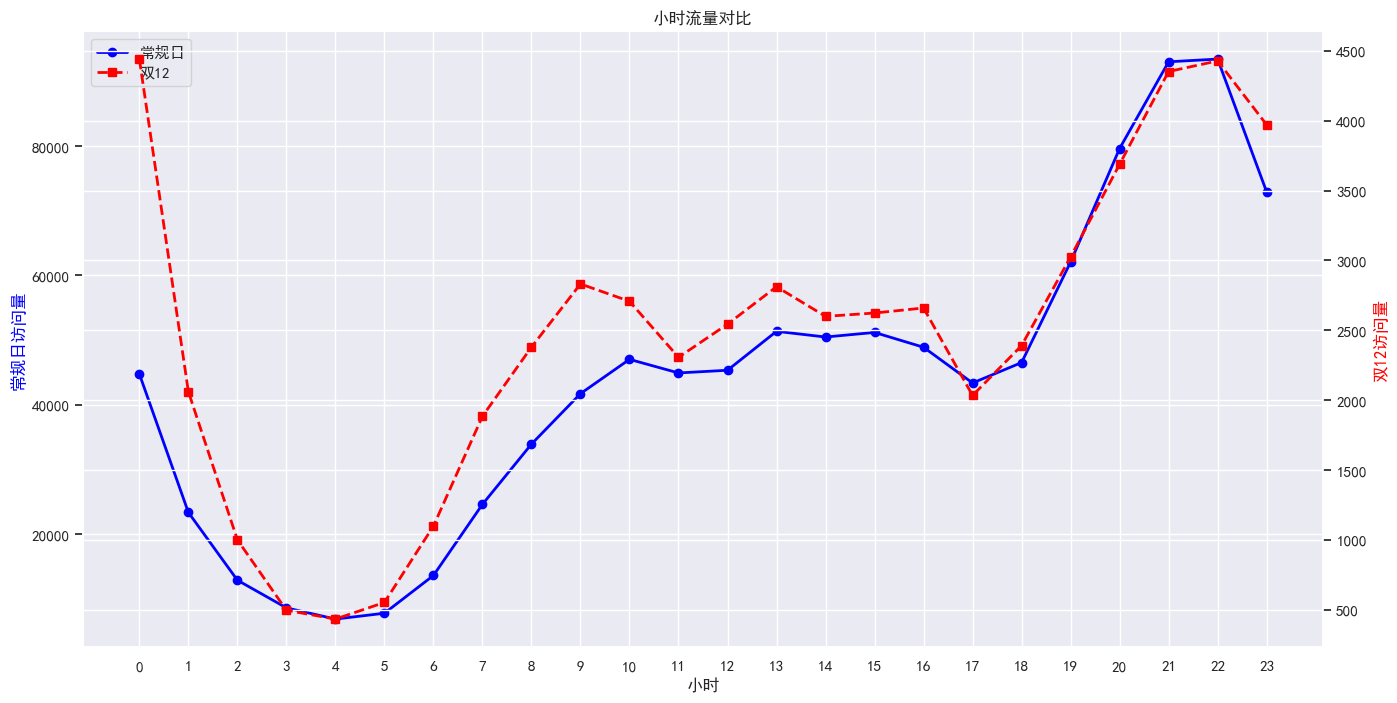

In [57]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示

# 1. 导入库 + 字体设置
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 2. 原始数据准备（
# 生成基础小时索引
hours = pd.DataFrame({'hour': range(24)})

# 3. 计算常规日数据
pv_hour = data_user.groupby('hour', as_index=False)['user_id'].count()
pv_hour = pv_hour.rename(columns={'user_id': 'pv_hour'})

# 4. 计算双12数据
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']
pv_hour_1212 = data_user_1212.groupby('hour', as_index=False)['user_id'].count()
pv_hour_1212 = pv_hour_1212.rename(columns={'user_id': '1212_pv_hour'})

# 5. 合并完整数据集
pv_hour_complete = hours.merge(pv_hour, on='hour', how='left').fillna(0)
pv_hour_1212_complete = hours.merge(pv_hour_1212, on='hour', how='left').fillna(0)

# 创建 merged_pv
merged_pv = pd.merge(
    pv_hour_complete,
    pv_hour_1212_complete,
    on='hour'
)

# 6. 双坐标轴可视化（完整代码）
plt.figure(figsize=(16, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(merged_pv['hour'], merged_pv['pv_hour'], 
         marker='o', label='常规日', color='blue', linewidth=2)
ax2.plot(merged_pv['hour'], merged_pv['1212_pv_hour'], 
         marker='s', label='双12', color='red', linestyle='--', linewidth=2)

ax1.set_xlabel('小时')
ax1.set_ylabel('常规日访问量', color='blue')
ax2.set_ylabel('双12访问量', color='red')
plt.title('小时流量对比')
plt.xticks(range(24))

# 合并图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

可以看到，双十二当天，PV变化趋与一个月内的PV变化趋势基本一致，只不过曲线不太平滑，多出来小的凸点，一个可能的原因是大促当天，有整点领券活动，通过推送等形式会有效拉动用户使用淘宝。

## Part2. 转化率分析

分析“浏览-收藏/加购-购买”链路的转化漏斗模型，可以了解各个环节的转化链路：

In [52]:
behavior_type = data_user.groupby(['behavior_type'])['user_id'].count()
behavior_type

behavior_type
1    987911
2     20997
3     29427
4     10240
Name: user_id, dtype: int64

In [53]:
behavior_type = data_user.groupby(['behavior_type'])['user_id'].count()
click_num = behavior_type[1]
fav_num = behavior_type[2]
add_num = behavior_type[3]
pay_num = behavior_type[4]

fav_add_num = fav_num + add_num 
print('点击 到 加购/收藏转化率:{:.2f}%'.format(100 * fav_add_num / click_num))
print('点击 到 购买转化率:{:.2f}%'.format(100 * pay_num / click_num))
print('加购/收藏 到 购买转化率:{:.2f}%'.format(100 * pay_num / fav_add_num))

点击 到 加购/收藏转化率:5.10%
点击 到 购买转化率:1.04%
加购/收藏 到 购买转化率:20.31%


In [54]:
behavior_type = data_user_1212.groupby(['behavior_type'])['user_id'].count()
click_num = behavior_type[1]
fav_num = behavior_type[2]
add_num = behavior_type[3]
pay_num = behavior_type[4]

fav_add_num = fav_num + add_num 
print('点击 到 加购/收藏转化率:{:.2f}%'.format(100 * fav_add_num / click_num))
print('点击 到 购买转化率:{:.2f}%'.format(100 * pay_num / click_num))
print('加购/收藏 到 购买转化率:{:.2f}%'.format(100 * pay_num / fav_add_num))

点击 到 加购/收藏转化率:5.54%
点击 到 购买转化率:2.35%
加购/收藏 到 购买转化率:42.41%


可以看出，双十二当天，加购/收藏 到 购买转化率是平时的2倍之多，此外，加购/收藏 的转化率也比平时高出不少，说明大促的运营活动对用户活跃度的转化起到了很好的促进作用。

## Part3. 用户价值分析

### 4. 用户购买频次分析

In [65]:
data_user_buy = data_user[data_user.behavior_type==4].groupby('user_id',as_index=False)['behavior_type'].count()
data_user_buy = data_user_buy.rename(columns = {"behavior_type":"purchase_count"})
data_user_buy.head()

,user_id,purchase_count
0,7591,4
1,12645,3
2,79824,1
3,88930,5
4,100539,3


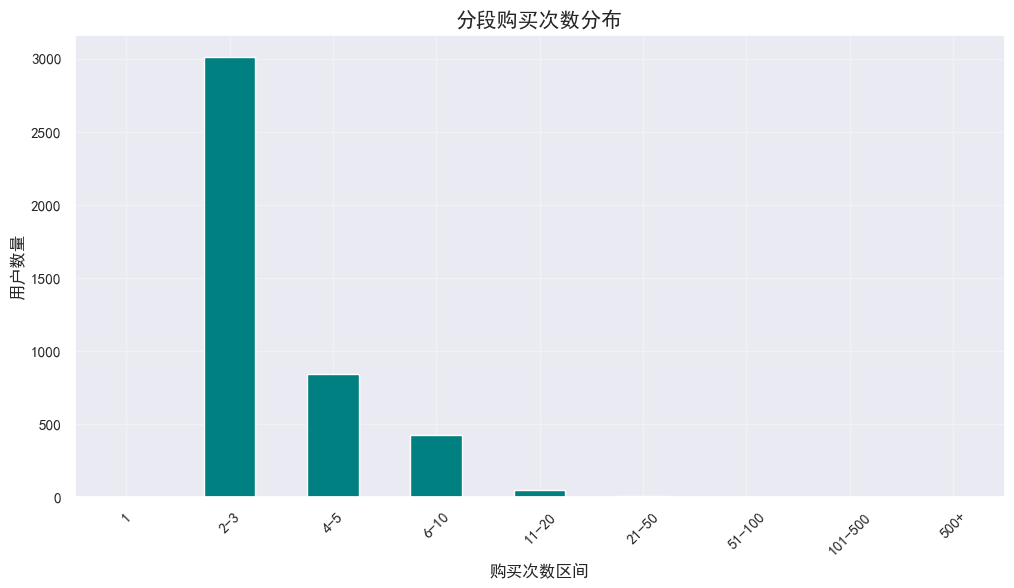

In [72]:
bins = [0, 1, 3, 5, 10, 20, 50, 100, 500, 1000]
labels = ['1', '2-3', '4-5', '6-10', '11-20', 
          '21-50', '51-100', '101-500', '500+']

segmented = pd.cut(data_user_buy['purchase_count'],
                  bins=bins,
                  labels=labels,
                  right=False).value_counts().sort_index()

plt.figure(figsize=(12, 6))
segmented.plot(kind='bar', color='teal')
plt.title('分段购买次数分布', fontsize=15)
plt.xlabel('购买次数区间', fontsize=12)
plt.ylabel('用户数量', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

这说明大多数用户本月购买的次数在2-10次之间

Text(0.5, 1.0, 'ARPU')

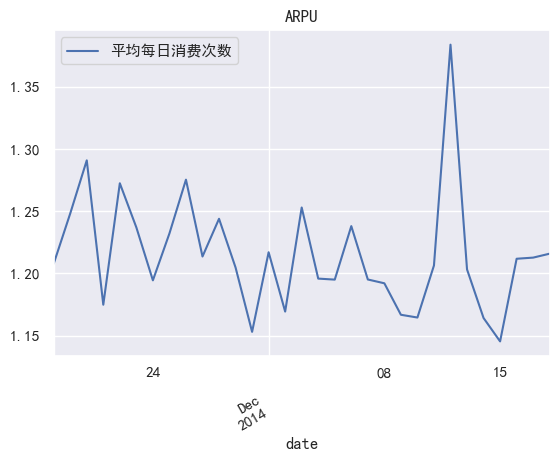

In [56]:
arpu = data_user[data_user['behavior_type'] == 4].groupby('date',as_index=False).agg(
    下单人数=('user_id', 'nunique'),  # 独立用户数
    下单次数=('user_id', 'count'),    # 总记录数
    平均每日消费次数=('user_id', lambda x: x.count() / x.nunique())) 
arpu
# 设置中文字体
arpu.plot(x='date',y='平均每日消费次数')
plt.gcf().autofmt_xdate()
plt.title('ARPU')